# Create the Environment 

Our environment contains one agent, one dynamic obstacle and one moving goal.  
Here, we initialize a 300 * 200 room with simple-playground.

In [62]:
from simple_playgrounds.playground.layouts import SingleRoom
from simple_playgrounds.engine import Engine
from simple_playgrounds.agent.controllers import Keyboard, External
from simple_playgrounds.agent.agents import BaseAgent, HeadAgent
from simple_playgrounds.device.sensors import RgbCamera, Lidar, SemanticCones, Touch
from simple_playgrounds.agent.agent import Agent
from simple_playgrounds.device.sensor import SensorDevice
from simple_playgrounds.element.elements.basic import Physical
import numpy as np
from numpy import pi

# to display the sensors
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

def plt_image(img):
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    

In [63]:
import math
my_playground = SingleRoom(size=(300, 200))
initial_position = (50,50)
initial_goal = (250, 170)

## Adding agents and sensors

Here, we add our agent, the obstacle and the goal.  
Our agent perceive its surrondings with a lidar sensor and a touch sensor.

In [64]:
my_agent = BaseAgent(controller=External(), interactive = True, radius = 10, lateral = True)
goal = BaseAgent(controller=External(), interactive = False, radius = 10)
my_agent.add_sensor(Touch(my_agent.base_platform, normalize = True, invisible_elements=my_agent.parts + goal.parts))
obstacle = BaseAgent(controller=External(), interactive = False, radius = 10)
my_agent.add_sensor(Lidar(my_agent.base_platform, normalize = True, invisible_elements=my_agent.parts + goal.parts))

my_playground.add_agent(my_agent, (initial_position, 1.5*pi/4))
my_playground.add_agent(obstacle, ((110,60), pi/2))
my_playground.add_agent(goal, (initial_goal, pi))

## Define some helper functions

In [138]:
# Convert the sensor values from 2d array to 1d
def array2d_to_1d(array_2d):
    array1d = np.zeros(len(array_2d))
    for i in range(len(array_2d)):
        if len(array_2d[i]) == 1:
            array1d[i] = array_2d[i][0] 
    return array1d


# The following functions are used to generate actions for the dynamic obstacle. 
# It takes the obstacle as input, output the actions of the obstacle (dictionary of {(actuator, value)}).

# Trajectory 1 of the obstacle
def generate_obstacle(agent):
    actions = {}
    for actuator in agent.controller.controlled_actuators:
        actions[actuator] = 0
    actions[agent.controller.controlled_actuators[1]] = 0.3
    actions[agent.controller.controlled_actuators[0]] = 0.5
    return actions

# Trajectory 2 of the obstacle
def generate_obstacle_2(agent, last_step):
    actions = {}
    l_step = 0
    for actuator in agent.controller.controlled_actuators:
        actions[actuator] = 0
    actions[agent.controller.controlled_actuators[0]] = 0.2
    if agent.coordinates[0][1] <= 60:
        l_step = 0.2
    if agent.coordinates[0][1] >= 140: 
        l_step = -0.2
    elif 55 < agent.coordinates[0][1] < 145:
        l_step = last_step
    actions[agent.controller.controlled_actuators[0]] = l_step
    return actions, l_step


# Calculate the distance from our agent to the goal
def dist_to_destination(agent, goal):
    x = agent.coordinates[0][0]
    y = agent.coordinates[0][1]
    dist =((x-goal[0])**2 + (y-goal[1])**2)**(1/2)
    t = ((goal[0])**2 + (goal[1])**2)**(1/2)
    norm_dist = dist / t
    return norm_dist


# Check if the agent is colliding with the obstacle or the wall.
def check_collision(sensor_values, agent):
    collision = False
    max_val = max(sensor_values)
    indices = []
    for i in range(len(sensor_values)):
         if sensor_values[i] == max_val:
                indices.append(i)
    in_front = True
    for ind in indices:
        if 13 <= ind < 27:
            in_front = True
            break

    if max_val > 0.9 and in_front:
        collision = True
    return collision

# Currently we don't use this function
def close_collision(sensor_values, agent):
    collision = False
    max_val = max(sensor_values)
    indices = []
    for i in range(len(sensor_values)):
         if sensor_values[i] == max_val:
                indices.append(i)
    in_front = False
    for ind in indices:
        if 13 <= ind < 27:
            in_front = True
            break

    if max_val > 0.7 and in_front:
        collision = True
    return collision


# Convert the action values from the reinforcement learning algorithms to dictionary of {(actuator, value)}
def custom_actions(action_values, agent):
    actions = {}
    longitudinal_force = action_values[0]
    angular_velocity = action_values[1]
    lateral_force = action_values[2]
    actions[agent.longitudinal_force] = longitudinal_force
    actions[agent.rotation_velocity] = angular_velocity
    actions[agent.lateral_force] = lateral_force
    actions[agent.activate] = 0
    actions[agent.grasp] = 0
    return actions

# Calculate the angle from our agent to the goal
def theta_to_destination(agent, goal):
    x = agent.coordinates[0][0]
    y = agent.coordinates[0][1]
    total = np.arctan((goal[0]-y)/(goal[1]-x))
    theta = np.radians(total) - agent.coordinates[1]
    theta_norm = theta / (2*np.pi)
    return theta_norm


# The following functions are used to generate actions for the moving goal. 
# It takes the goal agent as input, output the actions of the goal (dictionary of {(actuator, value)}).
def goal_moving(agent, last_step):
    actions = {}
    l_step = 0
    for actuator in agent.controller.controlled_actuators:
        actions[actuator] = 0
    actions[agent.controller.controlled_actuators[0]] = 0.2
    if agent.coordinates[0][0] <= 100:
        l_step = -0.2
    if agent.coordinates[0][0] >= 250: 
        l_step = 0.2
    elif 95 < agent.coordinates[0][0] < 255:
        l_step = last_step
    actions[agent.controller.controlled_actuators[0]] = l_step
    return actions, l_step

In [ ]:
import numpy as np
import gym
from gym import spaces

## Define our environment (Gym Interface)

In [127]:
class myEnv(gym.Env):
#     destination = (170, 170)
    def __init__(self, my_playground):
#         super(myEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        
        self.action_space = spaces.Box(np.array([0, -1, -1]), np.array([1, 1, 1]), dtype=np.float32)
        # The observation will be the coordinate of the agent
        # this can be described both by Discrete and Box space
        self.observation_space = spaces.Box(np.array([-1]+[0]*65), np.array([1]*66), dtype=np.float32)
#         self.observation_space = spaces.Box(low = 0, high = 1, shape = (66,), dtype=np.float32)
        self.engine = Engine(time_limit=100000, playground = my_playground)
        self.threshold = 0.1
        self.last_step = 0.2
        self.goal_initial = [250, 185]
        self.dist_to_goal = ((initial_position[0] - self.goal_initial[0])**2 + (initial_position[1] - self.goal_initial[1])**2)**(1/2)
        self.goal = [250, 185]
    def reset(self):
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """

        eng = self.engine
        eng.reset()
#         plt_image(eng.generate_playground_image())
        self.engine = eng
        sensor_vals_lidar = eng.agents[0].sensors[1].sensor_values
        
        self.dist_to_goal = ((initial_position[0] - self.goal_initial[0])**2 + (initial_position[1] - self.goal_initial[1])**2)**(1/2)
        
        if sensor_vals_lidar is None:
            sensor_vals_lidar = np.array([0]*64)
        else: 
            sensor_vals_lidar = array2d_to_1d(sensor_vals_lidar)
        dist = dist_to_destination(eng.agents[0], self.goal)
        theta = theta_to_destination(eng.agents[0], self.goal)
        obs = np.insert(sensor_vals_lidar, 0, dist)
        obs = np.insert(obs, 0, theta)
        return obs.astype(np.float32)

    def step(self, action_values):
        
        # Here we custom the action_values, generate the "actions" that can be taken by our playground engine
        actions = {}
        eng = self.engine
        actions[eng.agents[0]] = custom_actions(action_values, eng.agents[0])
        actions[eng.agents[2]], l = goal_moving(eng.agents[2], self.last_step)
#         actions[eng.agents[1]] = generate_obstacle(eng.agents[1])
        actions[eng.agents[1]], l = generate_obstacle_2(eng.agents[1], self.last_step) 
        self.last_step = l
        
        # Apply the actions 
        eng.step(actions)
        eng.update_observations()

#         cv2.imshow('agent', eng.generate_agent_image(eng.agents[0]))
#         cv2.waitKey(20)
        
        self.engine = eng
        
        # Custom the sensor values and distance to destination after our agent takes action
        sensor_vals_lidar = eng.agents[0].sensors[1].sensor_values
        sensor_vals_lidar = array2d_to_1d(sensor_vals_lidar)
        sensor_vals_touch = eng.agents[0].sensors[0].sensor_values
        sensor_vals_touch = array2d_to_1d(sensor_vals_touch)
        
        self.goal = []
        self.goal.append(eng.agents[2].coordinates[0][0])
        self.goal.append(eng.agents[2].coordinates[0][1])
        dist = dist_to_destination(eng.agents[0], self.goal)
        theta = theta_to_destination(eng.agents[0], self.goal)
        obs = np.insert(sensor_vals_lidar, 0, dist)
        obs = np.insert(obs, 0, theta)
        
        last_dist = self.dist_to_goal
        self.dist_to_goal = dist * (((self.goal[0])**2 + (self.goal[1])**2)**(1/2))

        reward = 0
        
        
#         If our agent collides with the obstacle (agent2), then gives reward -1000. 
#         If our agent arrives at the destination, then gives reward 2000.
#         Otherwise, gives reward -1. 
#         This doesn't work: hard exploration ---> sparse reward problem
        if check_collision(sensor_vals_touch, eng.agents[0]):
            reward = -0.5
#             print ("coordinates: ", eng.agents[0].coordinates[0])
#             print ("collision with obstacle!!!")
        if dist < self.threshold:
            reward = 1
        reward += -dist



        # Are we at the terminate state?
        done = bool(dist < self.threshold)
        if dist < self.threshold:
            print ("Goal reached!")

        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return obs.astype(np.float32), reward, done, info

    def render(self, mode='console'):
        if mode != 'console':
          raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
#         print("." * self.agent_pos, end="")
#         print("x", end="")
#         print("." * (self.grid_size - self.agent_pos))

    def close(self):
        pass
    

In [128]:
# from stable_baselines import DQN, PPO2, A2C, ACKTR
# from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.env_checker import check_env
# Instantiate the env
# env = myEnv()
# # wrap it
# env = make_vec_env(lambda: env, n_envs=1)

In [129]:
env = myEnv(my_playground)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [130]:
# Apply reinforcement learning methods
from stable_baselines3 import PPO, A2C, DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import TQC
# Instantiate the env
env = myEnv(my_playground)
# wrap it
env = make_vec_env(lambda: env, n_envs=1)


## Testing RL Algorithms (Box Spaces)

PPO, DDPG, A2C, HER, SAC, TD3, TQC

In [79]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)
model.save("PPO_moving_14")

Using cpu device
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 922      |
|    ep_rew_mean     | -853     |
| time/              |          |
|    fps             | 484      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 803         |
|    ep_rew_mean          | -679        |
| time/                   |             |
|    fps                  | 443         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008326479 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         |

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 139          |
|    ep_rew_mean          | -71.6        |
| time/                   |              |
|    fps                  | 413          |
|    iterations           | 10           |
|    time_elapsed         | 49           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0085563995 |
|    clip_fraction        | 0.0703       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.19        |
|    explained_variance   | -7.63e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 60.5

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63           |
|    ep_rew_mean          | -30.9        |
| time/                   |              |
|    fps                  | 407          |
|    iterations           | 17           |
|    time_elapsed         | 85           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0061530406 |
|    clip_fraction        | 0.0229       |
|    cli

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.4        |
|    ep_rew_mean          | -26.5       |
| time/                   |             |
|    fps                  | 404         |
|    iterations           | 23          |
|    time_elapsed         | 116         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.009371357 |
|    c

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 38.5         |
|    ep_rew_mean          | -18.7        |
| time/                   |              |
|    fps                  | 401          |
|    iterations           | 28           |
|    time_elapsed         | 142          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0072231507 |
|    clip_fraction        | 0.0787       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.91        |
|    explained_variance   | 0.773        |
|    learning_rate        | 0.000

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.6        |
|    ep_rew_mean          | -16         |
| time/                   |             |
|    fps            

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 28         |
|    ep_rew_mean          | -13        |
| time/                   |            |
|    fps                  | 31         |
|    iterations           | 37         |
|    time_elapsed         | 2386       |
|    total_timesteps      | 75776      |
| train/                  |            |
|    approx_kl            | 0.01753611 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.56      |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0811     |
|    n_updates            | 360        |
|    policy_gradient_loss | -0.0175    |
|    std                  | 0.79       |
|    value_loss           | 0.186      |

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal r

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal r

In [91]:
model = PPO.load("PPO_moving_14")
obs = env.reset()
n_steps = 1000

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
#     print("Action: ", action)
    obs, reward, done, info = env.step(action) 
#     print('obs=', obs, 'reward=', reward, 'done=', done)
    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Done!", "reward=", reward)
        break

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Goal reached!
Done! reward= [0.9205743]


In [143]:
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)
model.save("a2c_moving5")

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 407      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.31    |
|    explained_variance | -0.00876 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -5.48    |
|    std                | 1.02     |
|    value_loss         | 1.23     |
------------------------------------
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 828      |
|    ep_rew_mean        | -470     |
| time/                 |          |
|    fps                | 411      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -4.31    |
|    ex

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 407      |
|    iterations         | 1400     |
|    time_elapsed       | 17       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -4.42    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | -19.6    |
|    std                | 1.06     |
|    value_loss         | 21.3     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 406      |
|    iterations         | 1500     |
|    time_elapsed       | 18       |
|    total_timesteps    | 7500     |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 430      |
|    iterations         | 2700     |
|    time_elapsed       | 31       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -4.52    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | -18.8    |
|    std                | 1.09     |
|    value_loss         | 23.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 432      |
|    iterations         | 2800     |
|    time_elapsed       | 32       |
|    total_timesteps    | 14000    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 446      |
|    iterations         | 4000     |
|    time_elapsed       | 44       |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -4.6     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | -117     |
|    std                | 1.12     |
|    value_loss         | 499      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 447      |
|    iterations         | 4100     |
|    time_elapsed       | 45       |
|    total_timesteps    | 20500    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 924       |
|    ep_rew_mean        | -674      |
| time/                 |           |
|    fps                | 454       |
|    iterations         | 5300      |
|    time_elapsed       | 58        |
|    total_timesteps    | 26500     |
| train/                |           |
|    entropy_loss       | -4.67     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 5299      |
|    policy_loss        | -134      |
|    std                | 1.15      |
|    value_loss         | 798       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 455      |
|    iterations         | 5400     |
|    time_elapsed       | 59       |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 460      |
|    iterations         | 6600     |
|    time_elapsed       | 71       |
|    total_timesteps    | 33000    |
| train/                |          |
|    entropy_loss       | -4.82    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 6599     |
|    policy_loss        | -97.3    |
|    std                | 1.2      |
|    value_loss         | 331      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 460      |
|    iterations         | 6700     |
|    time_elapsed       | 72       |
|    total_timesteps    | 33500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 463      |
|    iterations         | 7900     |
|    time_elapsed       | 85       |
|    total_timesteps    | 39500    |
| train/                |          |
|    entropy_loss       | -4.99    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 7899     |
|    policy_loss        | -108     |
|    std                | 1.28     |
|    value_loss         | 598      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 463      |
|    iterations         | 8000     |
|    time_elapsed       | 86       |
|    total_timesteps    | 40000    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 465      |
|    iterations         | 9200     |
|    time_elapsed       | 98       |
|    total_timesteps    | 46000    |
| train/                |          |
|    entropy_loss       | -5.1     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 9199     |
|    policy_loss        | -47.5    |
|    std                | 1.33     |
|    value_loss         | 147      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 465      |
|    iterations         | 9300     |
|    time_elapsed       | 99       |
|    total_timesteps    | 46500    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 924       |
|    ep_rew_mean        | -674      |
| time/                 |           |
|    fps                | 456       |
|    iterations         | 10500     |
|    time_elapsed       | 115       |
|    total_timesteps    | 52500     |
| train/                |           |
|    entropy_loss       | -5.23     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 10499     |
|    policy_loss        | -33.5     |
|    std                | 1.38      |
|    value_loss         | 36.6      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 924       |
|    ep_rew_mean        | -674      |
| time/                 |           |
|    fps                | 454       |
|    iterations         | 10600     |
|    time_elapsed       | 116       |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 450      |
|    iterations         | 11800    |
|    time_elapsed       | 130      |
|    total_timesteps    | 59000    |
| train/                |          |
|    entropy_loss       | -5.22    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 11799    |
|    policy_loss        | -21.4    |
|    std                | 1.38     |
|    value_loss         | 23.1     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 451      |
|    iterations         | 11900    |
|    time_elapsed       | 131      |
|    total_timesteps    | 59500    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 924       |
|    ep_rew_mean        | -674      |
| time/                 |           |
|    fps                | 452       |
|    iterations         | 13100     |
|    time_elapsed       | 144       |
|    total_timesteps    | 65500     |
| train/                |           |
|    entropy_loss       | -5.28     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 13099     |
|    policy_loss        | -33.8     |
|    std                | 1.41      |
|    value_loss         | 58.7      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 452      |
|    iterations         | 13200    |
|    time_elapsed       | 145      |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 454      |
|    iterations         | 14400    |
|    time_elapsed       | 158      |
|    total_timesteps    | 72000    |
| train/                |          |
|    entropy_loss       | -5.31    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 14399    |
|    policy_loss        | -95.2    |
|    std                | 1.42     |
|    value_loss         | 206      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 454      |
|    iterations         | 14500    |
|    time_elapsed       | 159      |
|    total_timesteps    | 72500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 455      |
|    iterations         | 15700    |
|    time_elapsed       | 172      |
|    total_timesteps    | 78500    |
| train/                |          |
|    entropy_loss       | -5.48    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 15699    |
|    policy_loss        | -34.2    |
|    std                | 1.5      |
|    value_loss         | 53.7     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 455      |
|    iterations         | 15800    |
|    time_elapsed       | 173      |
|    total_timesteps    | 79000    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 457      |
|    iterations         | 17000    |
|    time_elapsed       | 185      |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | -5.52    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 16999    |
|    policy_loss        | -34.8    |
|    std                | 1.52     |
|    value_loss         | 50.9     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 457      |
|    iterations         | 17100    |
|    time_elapsed       | 186      |
|    total_timesteps    | 85500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 457      |
|    iterations         | 18300    |
|    time_elapsed       | 199      |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | -5.45    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 18299    |
|    policy_loss        | -4.85    |
|    std                | 1.49     |
|    value_loss         | 0.55     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 924      |
|    ep_rew_mean        | -674     |
| time/                 |          |
|    fps                | 457      |
|    iterations         | 18400    |
|    time_elapsed       | 200      |
|    total_timesteps    | 92000    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 924       |
|    ep_rew_mean        | -674      |
| time/                 |           |
|    fps                | 458       |
|    iterations         | 19600     |
|    time_elapsed       | 213       |
|    total_timesteps    | 98000     |
| train/                |           |
|    entropy_loss       | -5.47     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 19599     |
|    policy_loss        | -5.36     |
|    std                | 1.5       |
|    value_loss         | 1.62      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 924       |
|    ep_rew_mean        | -674      |
| time/                 |           |
|    fps                | 458       |
|    iterations         | 19700     |
|    time_elapsed       | 214       |
|    total_t

In [142]:
model = A2C.load("a2c_moving5")
obs = env.reset()
n_steps = 1000

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
#     print("Action: ", action)
    obs, reward, done, info = env.step(action)
#     print('obs=', obs, 'reward=', reward, 'done=', done)
#     env.render(mode='console')
    if done:
        print("Done!", "reward=", reward)
        break

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Step 123
S

Step 962
Step 963
Step 964
Step 965
Step 966
Step 967
Step 968
Step 969
Step 970
Step 971
Step 972
Step 973
Step 974
Step 975
Step 976
Step 977
Step 978
Step 979
Step 980
Step 981
Step 982
Step 983
Step 984
Step 985
Step 986
Step 987
Step 988
Step 989
Step 990
Step 991
Step 992
Step 993
Step 994
Step 995
Step 996
Step 997
Step 998
Step 999
Step 1000


In [135]:
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=100000, log_interval=10)
model.save("ddpg_moving")

Using cpu device
Goal reached!
Goal reached!
Goal reached!


KeyboardInterrupt: 

In [ ]:
obs = env.reset()
n_steps = 500
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
    print("Action: ", action)
    obs, reward, done, info = env.step(action)
    print('obs=', obs, 'reward=', reward, 'done=', done)
    env.render(mode='console')
    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Done!", "reward=", reward)
        break

In [108]:
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000, log_interval=4)
# 4 is with 20000 timesteps, collide once reach goal in 23 steps. -0.5, 1 and -dist
model.save("sac_moving6")

Using cpu device
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 336      |
|    ep_rew_mean     | -341     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 41       |
|    time_elapsed    | 32       |
|    total_timesteps | 1346     |
| train/             |          |
|    actor_loss      | -5.07    |
|    critic_loss     | 0.0573   |
|    ent_coef        | 0.689    |
|    ent_coef_loss   | -1.87    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1245     |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 265      |
|    ep_rew_mean     | -256     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 40       |
|    time_elapsed    | 52       |
|    total_timesteps 

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 248      |
|    ep_rew_mean     | -125     |
| time/              |          |
|    episodes        | 56       |
|    fps             | 42       |
|    time_elapsed    | 324      |
|    total_timesteps | 13898    |
| train/             |          |
|    actor_loss      | 6.14     |
|    critic_loss     | 0.135    |
|    ent_coef        | 0.0197   |
|    ent_coef_loss   | -8.02    |
|    learning_rate   | 0.0003   |
|    n_updates       | 13797    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 238      |
|    ep_rew_mean     | -119     |
| time/              |          |
|    episodes        | 60       |
|    fps             | 42       |
|    time_elapsed    | 332      |
|    total_timesteps | 14274    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_mean     | -59.7    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 43       |
|    time_elapsed    | 378      |
|    total_timesteps | 16354    |
| train/             |          |
|    actor_loss      | 7.71     |
|    critic_loss     | 0.165    |
|    ent_coef        | 0.0122   |
|    ent_coef_loss   | -1.44    |
|    learning_rate   | 0.0003   |
|    n_updates       | 16253    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 133      |
|    ep_rew_mean     | -53.9    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 43       |
|    time_elapsed    | 381      |
|    total_timesteps | 16487    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.7     |
|    ep_rew_mean     | -16.3    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 43       |
|    time_elapsed    | 415      |
|    total_timesteps | 18042    |
| train/             |          |
|    actor_loss      | 9.01     |
|    critic_loss     | 0.276    |
|    ent_coef        | 0.0124   |
|    ent_coef_loss   | 0.436    |
|    learning_rate   | 0.0003   |
|    n_updates       | 17941    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.5     |
|    ep_rew_mean     | -15.7    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 43       |
|    time_elapsed    | 418      |
|    total_timesteps | 18171    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.3     |
|    ep_rew_mean     | -14.7    |
| time/              |          |
|    episodes        | 212      |
|    fps             | 43       |
|    time_elapsed    | 452      |
|    total_timesteps | 19715    |
| train/             |          |
|    actor_loss      | 7.67     |
|    critic_loss     | 0.188    |
|    ent_coef        | 0.0147   |
|    ent_coef_loss   | -0.223   |
|    learning_rate   | 0.0003   |
|    n_updates       | 19614    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.2     |
|    ep_rew_mean     | -14.6    |
| time/              |          |
|    episodes        | 216      |
|    fps             | 43       |
|    time_elapsed    | 454      |
|    total_timesteps | 19844    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.4     |
|    ep_rew_mean     | -14.6    |
| time/              |          |
|    episodes        | 264      |
|    fps             | 43       |
|    time_elapsed    | 488      |
|    total_timesteps | 21408    |
| train/             |          |
|    actor_loss      | 7.55     |
|    critic_loss     | 0.206    |
|    ent_coef        | 0.0154   |
|    ent_coef_loss   | -1.45    |
|    learning_rate   | 0.0003   |
|    n_updates       | 21307    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.4     |
|    ep_rew_mean     | -14.7    |
| time/              |          |
|    episodes        | 268      |
|    fps             | 43       |
|    time_elapsed    | 491      |
|    total_timesteps | 21541    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.4     |
|    ep_rew_mean     | -14.6    |
| time/              |          |
|    episodes        | 316      |
|    fps             | 43       |
|    time_elapsed    | 524      |
|    total_timesteps | 23079    |
| train/             |          |
|    actor_loss      | 6.9      |
|    critic_loss     | 0.19     |
|    ent_coef        | 0.0141   |
|    ent_coef_loss   | -0.302   |
|    learning_rate   | 0.0003   |
|    n_updates       | 22978    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.3     |
|    ep_rew_mean     | -14.6    |
| time/              |          |
|    episodes        | 320      |
|    fps             | 43       |
|    time_elapsed    | 527      |
|    total_timesteps | 23205    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.7     |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 43       |
|    time_elapsed    | 563      |
|    total_timesteps | 24710    |
| train/             |          |
|    actor_loss      | 6.92     |
|    critic_loss     | 0.168    |
|    ent_coef        | 0.013    |
|    ent_coef_loss   | 0.149    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24609    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.6     |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    episodes        | 372      |
|    fps             | 43       |
|    time_elapsed    | 566      |
|    total_timesteps | 24833    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.1     |
|    ep_rew_mean     | -14.1    |
| time/              |          |
|    episodes        | 420      |
|    fps             | 43       |
|    time_elapsed    | 600      |
|    total_timesteps | 26310    |
| train/             |          |
|    actor_loss      | 6.87     |
|    critic_loss     | 0.129    |
|    ent_coef        | 0.0122   |
|    ent_coef_loss   | 0.824    |
|    learning_rate   | 0.0003   |
|    n_updates       | 26209    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31       |
|    ep_rew_mean     | -14.1    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 43       |
|    time_elapsed    | 603      |
|    total_timesteps | 26435    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.9     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 472      |
|    fps             | 43       |
|    time_elapsed    | 635      |
|    total_timesteps | 27918    |
| train/             |          |
|    actor_loss      | 5.74     |
|    critic_loss     | 0.101    |
|    ent_coef        | 0.0117   |
|    ent_coef_loss   | -0.758   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27817    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.8     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 476      |
|    fps             | 43       |
|    time_elapsed    | 637      |
|    total_timesteps | 28040    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.7     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 524      |
|    fps             | 44       |
|    time_elapsed    | 670      |
|    total_timesteps | 29509    |
| train/             |          |
|    actor_loss      | 6.18     |
|    critic_loss     | 0.112    |
|    ent_coef        | 0.0114   |
|    ent_coef_loss   | 0.983    |
|    learning_rate   | 0.0003   |
|    n_updates       | 29408    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.7     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 528      |
|    fps             | 44       |
|    time_elapsed    | 672      |
|    total_timesteps | 29631    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.6     |
|    ep_rew_mean     | -13.9    |
| time/              |          |
|    episodes        | 576      |
|    fps             | 44       |
|    time_elapsed    | 705      |
|    total_timesteps | 31099    |
| train/             |          |
|    actor_loss      | 5.72     |
|    critic_loss     | 0.114    |
|    ent_coef        | 0.0111   |
|    ent_coef_loss   | 0.569    |
|    learning_rate   | 0.0003   |
|    n_updates       | 30998    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.6     |
|    ep_rew_mean     | -13.9    |
| time/              |          |
|    episodes        | 580      |
|    fps             | 44       |
|    time_elapsed    | 708      |
|    total_timesteps | 31219    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.4     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 628      |
|    fps             | 44       |
|    time_elapsed    | 740      |
|    total_timesteps | 32667    |
| train/             |          |
|    actor_loss      | 6.49     |
|    critic_loss     | 0.09     |
|    ent_coef        | 0.0112   |
|    ent_coef_loss   | 1.38     |
|    learning_rate   | 0.0003   |
|    n_updates       | 32566    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.3     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 632      |
|    fps             | 44       |
|    time_elapsed    | 742      |
|    total_timesteps | 32788    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.2     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 680      |
|    fps             | 44       |
|    time_elapsed    | 773      |
|    total_timesteps | 34244    |
| train/             |          |
|    actor_loss      | 6.17     |
|    critic_loss     | 0.0771   |
|    ent_coef        | 0.0109   |
|    ent_coef_loss   | 0.219    |
|    learning_rate   | 0.0003   |
|    n_updates       | 34143    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.3     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 684      |
|    fps             | 44       |
|    time_elapsed    | 776      |
|    total_timesteps | 34368    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.4     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 732      |
|    fps             | 44       |
|    time_elapsed    | 807      |
|    total_timesteps | 35825    |
| train/             |          |
|    actor_loss      | 5.32     |
|    critic_loss     | 0.0686   |
|    ent_coef        | 0.0106   |
|    ent_coef_loss   | -1.16    |
|    learning_rate   | 0.0003   |
|    n_updates       | 35724    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.4     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 736      |
|    fps             | 44       |
|    time_elapsed    | 810      |
|    total_timesteps | 35944    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.2     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 784      |
|    fps             | 44       |
|    time_elapsed    | 841      |
|    total_timesteps | 37392    |
| train/             |          |
|    actor_loss      | 5.57     |
|    critic_loss     | 0.0665   |
|    ent_coef        | 0.01     |
|    ent_coef_loss   | -0.00427 |
|    learning_rate   | 0.0003   |
|    n_updates       | 37291    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.2     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 788      |
|    fps             | 44       |
|    time_elapsed    | 843      |
|    total_timesteps | 37512    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.1     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 836      |
|    fps             | 44       |
|    time_elapsed    | 874      |
|    total_timesteps | 38953    |
| train/             |          |
|    actor_loss      | 5.49     |
|    critic_loss     | 0.0611   |
|    ent_coef        | 0.00987  |
|    ent_coef_loss   | -2.61    |
|    learning_rate   | 0.0003   |
|    n_updates       | 38852    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.1     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 840      |
|    fps             | 44       |
|    time_elapsed    | 877      |
|    total_timesteps | 39074    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 888      |
|    fps             | 44       |
|    time_elapsed    | 907      |
|    total_timesteps | 40509    |
| train/             |          |
|    actor_loss      | 5.62     |
|    critic_loss     | 0.0563   |
|    ent_coef        | 0.00971  |
|    ent_coef_loss   | -0.716   |
|    learning_rate   | 0.0003   |
|    n_updates       | 40408    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.9     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 892      |
|    fps             | 44       |
|    time_elapsed    | 910      |
|    total_timesteps | 40628    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.9     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 940      |
|    fps             | 44       |
|    time_elapsed    | 941      |
|    total_timesteps | 42067    |
| train/             |          |
|    actor_loss      | 5.35     |
|    critic_loss     | 0.0468   |
|    ent_coef        | 0.00929  |
|    ent_coef_loss   | -0.424   |
|    learning_rate   | 0.0003   |
|    n_updates       | 41966    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.9     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 944      |
|    fps             | 44       |
|    time_elapsed    | 943      |
|    total_timesteps | 42185    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.9     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 992      |
|    fps             | 44       |
|    time_elapsed    | 974      |
|    total_timesteps | 43614    |
| train/             |          |
|    actor_loss      | 5.51     |
|    critic_loss     | 0.0485   |
|    ent_coef        | 0.00917  |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 0.0003   |
|    n_updates       | 43513    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.9     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 996      |
|    fps             | 44       |
|    time_elapsed    | 976      |
|    total_timesteps | 43735    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.7     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1044     |
|    fps             | 44       |
|    time_elapsed    | 1007     |
|    total_timesteps | 45154    |
| train/             |          |
|    actor_loss      | 5.16     |
|    critic_loss     | 0.0496   |
|    ent_coef        | 0.00904  |
|    ent_coef_loss   | -0.291   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45053    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.7     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1048     |
|    fps             | 44       |
|    time_elapsed    | 1009     |
|    total_timesteps | 45274    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.7     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1096     |
|    fps             | 16       |
|    time_elapsed    | 2843     |
|    total_timesteps | 46702    |
| train/             |          |
|    actor_loss      | 5.49     |
|    critic_loss     | 0.0433   |
|    ent_coef        | 0.00843  |
|    ent_coef_loss   | 0.553    |
|    learning_rate   | 0.0003   |
|    n_updates       | 46601    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.7     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 16       |
|    time_elapsed    | 2846     |
|    total_timesteps | 46819    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.6     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1148     |
|    fps             | 16       |
|    time_elapsed    | 2884     |
|    total_timesteps | 48236    |
| train/             |          |
|    actor_loss      | 5.28     |
|    critic_loss     | 0.049    |
|    ent_coef        | 0.00855  |
|    ent_coef_loss   | -1.74    |
|    learning_rate   | 0.0003   |
|    n_updates       | 48135    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.6     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1152     |
|    fps             | 16       |
|    time_elapsed    | 2887     |
|    total_timesteps | 48354    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.5     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1200     |
|    fps             | 17       |
|    time_elapsed    | 2925     |
|    total_timesteps | 49769    |
| train/             |          |
|    actor_loss      | 5.72     |
|    critic_loss     | 0.0449   |
|    ent_coef        | 0.00825  |
|    ent_coef_loss   | 0.352    |
|    learning_rate   | 0.0003   |
|    n_updates       | 49668    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.5     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 17       |
|    time_elapsed    | 2928     |
|    total_timesteps | 49886    |
| tr

In [114]:
model = SAC.load("sac_moving6")
       
obs = env.reset()
n_steps = 2000

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
#     print("Action: ", action)
    obs, reward, done, info = env.step(action)
#     print('obs=', obs, 'reward=', reward, 'done=', done)
    env.render(mode='console')
    if done:
        print("Done!", "reward=", reward)
        break

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Goal reached!
Done! reward= [0.92288977]


In [381]:
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = TD3("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=25000, log_interval=10)
model.save("td3_DynamicObstacle")

NameError: name 'TD3' is not defined

In [119]:
policy_kwargs = dict(n_critics=2, n_quantiles=25)
model = TQC("MlpPolicy", env, top_quantiles_to_drop_per_net=2, verbose=1, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=100000, log_interval=4)
model.save("tqc_DynamicObstacle")

Using cpu device
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 422      |
|    ep_rew_mean     | -377     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 26       |
|    time_elapsed    | 62       |
|    total_timesteps | 1686     |
| train/             |          |
|    actor_loss      | -5.94    |
|    critic_loss     | 0.0273   |
|    ent_coef        | 0.622    |
|    ent_coef_loss   | -2.38    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1585     |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 320      |
|    ep_rew_mean     | -264     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 27       |
|    time_elapsed    | 94       |
|    total_timesteps 

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 177      |
|    ep_rew_mean     | -98.3    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 27       |
|    time_elapsed    | 363      |
|    total_timesteps | 9930     |
| train/             |          |
|    actor_loss      | -1.64    |
|    critic_loss     | 0.126    |
|    ent_coef        | 0.0569   |
|    ent_coef_loss   | -10.1    |
|    learning_rate   | 0.0003   |
|    n_updates       | 9829     |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 168      |
|    ep_rew_mean     | -93.1    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 27       |
|    time_elapsed    | 369      |
|    total_timesteps | 10103    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.9     |
|    ep_rew_mean     | -44.1    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 27       |
|    time_elapsed    | 445      |
|    total_timesteps | 12154    |
| train/             |          |
|    actor_loss      | 2.01     |
|    critic_loss     | 0.125    |
|    ent_coef        | 0.0313   |
|    ent_coef_loss   | -8.34    |
|    learning_rate   | 0.0003   |
|    n_updates       | 12053    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.3     |
|    ep_rew_mean     | -42.5    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 27       |
|    time_elapsed    | 450      |
|    total_timesteps | 12301    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.9     |
|    ep_rew_mean     | -18.5    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 27       |
|    time_elapsed    | 525      |
|    total_timesteps | 14296    |
| train/             |          |
|    actor_loss      | 4.29     |
|    critic_loss     | 0.0669   |
|    ent_coef        | 0.0185   |
|    ent_coef_loss   | -6.74    |
|    learning_rate   | 0.0003   |
|    n_updates       | 14195    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.7     |
|    ep_rew_mean     | -18.4    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 27       |
|    time_elapsed    | 531      |
|    total_timesteps | 14432    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.6     |
|    ep_rew_mean     | -17.4    |
| time/              |          |
|    episodes        | 212      |
|    fps             | 27       |
|    time_elapsed    | 603      |
|    total_timesteps | 16461    |
| train/             |          |
|    actor_loss      | 5.76     |
|    critic_loss     | 0.0469   |
|    ent_coef        | 0.0113   |
|    ent_coef_loss   | -2.27    |
|    learning_rate   | 0.0003   |
|    n_updates       | 16360    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.2     |
|    ep_rew_mean     | -17.5    |
| time/              |          |
|    episodes        | 216      |
|    fps             | 27       |
|    time_elapsed    | 611      |
|    total_timesteps | 16670    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.3     |
|    ep_rew_mean     | -15.6    |
| time/              |          |
|    episodes        | 264      |
|    fps             | 27       |
|    time_elapsed    | 659      |
|    total_timesteps | 18165    |
| train/             |          |
|    actor_loss      | 5.92     |
|    critic_loss     | 0.0419   |
|    ent_coef        | 0.00828  |
|    ent_coef_loss   | -2.94    |
|    learning_rate   | 0.0003   |
|    n_updates       | 18064    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.1     |
|    ep_rew_mean     | -15.5    |
| time/              |          |
|    episodes        | 268      |
|    fps             | 27       |
|    time_elapsed    | 662      |
|    total_timesteps | 18284    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 316      |
|    fps             | 27       |
|    time_elapsed    | 706      |
|    total_timesteps | 19668    |
| train/             |          |
|    actor_loss      | 6.64     |
|    critic_loss     | 0.0373   |
|    ent_coef        | 0.00787  |
|    ent_coef_loss   | 0.504    |
|    learning_rate   | 0.0003   |
|    n_updates       | 19567    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.9     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 320      |
|    fps             | 27       |
|    time_elapsed    | 709      |
|    total_timesteps | 19784    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.8     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 368      |
|    fps             | 28       |
|    time_elapsed    | 753      |
|    total_timesteps | 21167    |
| train/             |          |
|    actor_loss      | 7        |
|    critic_loss     | 0.043    |
|    ent_coef        | 0.00874  |
|    ent_coef_loss   | 1.39     |
|    learning_rate   | 0.0003   |
|    n_updates       | 21066    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.8     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 372      |
|    fps             | 28       |
|    time_elapsed    | 756      |
|    total_timesteps | 21282    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.8     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 420      |
|    fps             | 28       |
|    time_elapsed    | 801      |
|    total_timesteps | 22665    |
| train/             |          |
|    actor_loss      | 6.27     |
|    critic_loss     | 0.0373   |
|    ent_coef        | 0.00967  |
|    ent_coef_loss   | 0.544    |
|    learning_rate   | 0.0003   |
|    n_updates       | 22564    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.9     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 28       |
|    time_elapsed    | 805      |
|    total_timesteps | 22782    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29       |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 472      |
|    fps             | 28       |
|    time_elapsed    | 857      |
|    total_timesteps | 24186    |
| train/             |          |
|    actor_loss      | 5.86     |
|    critic_loss     | 0.0355   |
|    ent_coef        | 0.00987  |
|    ent_coef_loss   | -2.23    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24085    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.1     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 476      |
|    fps             | 28       |
|    time_elapsed    | 861      |
|    total_timesteps | 24306    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.3     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 524      |
|    fps             | 28       |
|    time_elapsed    | 908      |
|    total_timesteps | 25714    |
| train/             |          |
|    actor_loss      | 5.7      |
|    critic_loss     | 0.0336   |
|    ent_coef        | 0.00958  |
|    ent_coef_loss   | -2.52    |
|    learning_rate   | 0.0003   |
|    n_updates       | 25613    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.3     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 528      |
|    fps             | 28       |
|    time_elapsed    | 913      |
|    total_timesteps | 25830    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 576      |
|    fps             | 28       |
|    time_elapsed    | 962      |
|    total_timesteps | 27241    |
| train/             |          |
|    actor_loss      | 6.39     |
|    critic_loss     | 0.0273   |
|    ent_coef        | 0.00906  |
|    ent_coef_loss   | -0.312   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27140    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 580      |
|    fps             | 28       |
|    time_elapsed    | 967      |
|    total_timesteps | 27361    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 628      |
|    fps             | 28       |
|    time_elapsed    | 1016     |
|    total_timesteps | 28769    |
| train/             |          |
|    actor_loss      | 5.93     |
|    critic_loss     | 0.031    |
|    ent_coef        | 0.00876  |
|    ent_coef_loss   | -0.856   |
|    learning_rate   | 0.0003   |
|    n_updates       | 28668    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 632      |
|    fps             | 28       |
|    time_elapsed    | 1021     |
|    total_timesteps | 28889    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.3     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 680      |
|    fps             | 28       |
|    time_elapsed    | 1072     |
|    total_timesteps | 30293    |
| train/             |          |
|    actor_loss      | 5.66     |
|    critic_loss     | 0.0243   |
|    ent_coef        | 0.00878  |
|    ent_coef_loss   | -1.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 30192    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.3     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 684      |
|    fps             | 28       |
|    time_elapsed    | 1075     |
|    total_timesteps | 30410    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.1     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 732      |
|    fps             | 28       |
|    time_elapsed    | 1123     |
|    total_timesteps | 31800    |
| train/             |          |
|    actor_loss      | 5.83     |
|    critic_loss     | 0.021    |
|    ent_coef        | 0.00825  |
|    ent_coef_loss   | -1.06    |
|    learning_rate   | 0.0003   |
|    n_updates       | 31699    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.1     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 736      |
|    fps             | 28       |
|    time_elapsed    | 1127     |
|    total_timesteps | 31918    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.9     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 784      |
|    fps             | 28       |
|    time_elapsed    | 1175     |
|    total_timesteps | 33295    |
| train/             |          |
|    actor_loss      | 5.72     |
|    critic_loss     | 0.0198   |
|    ent_coef        | 0.00815  |
|    ent_coef_loss   | 2.02     |
|    learning_rate   | 0.0003   |
|    n_updates       | 33194    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.8     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 788      |
|    fps             | 28       |
|    time_elapsed    | 1179     |
|    total_timesteps | 33407    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 836      |
|    fps             | 28       |
|    time_elapsed    | 1226     |
|    total_timesteps | 34778    |
| train/             |          |
|    actor_loss      | 5.32     |
|    critic_loss     | 0.0195   |
|    ent_coef        | 0.00787  |
|    ent_coef_loss   | -0.747   |
|    learning_rate   | 0.0003   |
|    n_updates       | 34677    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 840      |
|    fps             | 28       |
|    time_elapsed    | 1230     |
|    total_timesteps | 34889    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 888      |
|    fps             | 28       |
|    time_elapsed    | 1279     |
|    total_timesteps | 36264    |
| train/             |          |
|    actor_loss      | 5.72     |
|    critic_loss     | 0.0195   |
|    ent_coef        | 0.0079   |
|    ent_coef_loss   | -1.41    |
|    learning_rate   | 0.0003   |
|    n_updates       | 36163    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 892      |
|    fps             | 28       |
|    time_elapsed    | 1283     |
|    total_timesteps | 36376    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 940      |
|    fps             | 28       |
|    time_elapsed    | 1334     |
|    total_timesteps | 37831    |
| train/             |          |
|    actor_loss      | 5.27     |
|    critic_loss     | 0.0174   |
|    ent_coef        | 0.00769  |
|    ent_coef_loss   | 2.65     |
|    learning_rate   | 0.0003   |
|    n_updates       | 37730    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 944      |
|    fps             | 28       |
|    time_elapsed    | 1338     |
|    total_timesteps | 37944    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.2     |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    episodes        | 992      |
|    fps             | 28       |
|    time_elapsed    | 1392     |
|    total_timesteps | 39500    |
| train/             |          |
|    actor_loss      | 5.7      |
|    critic_loss     | 0.0185   |
|    ent_coef        | 0.00779  |
|    ent_coef_loss   | 0.739    |
|    learning_rate   | 0.0003   |
|    n_updates       | 39399    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.3     |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    episodes        | 996      |
|    fps             | 28       |
|    time_elapsed    | 1396     |
|    total_timesteps | 39616    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.5     |
|    ep_rew_mean     | -14.2    |
| time/              |          |
|    episodes        | 1044     |
|    fps             | 28       |
|    time_elapsed    | 1452     |
|    total_timesteps | 41189    |
| train/             |          |
|    actor_loss      | 5.23     |
|    critic_loss     | 0.0218   |
|    ent_coef        | 0.00796  |
|    ent_coef_loss   | 0.242    |
|    learning_rate   | 0.0003   |
|    n_updates       | 41088    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.8     |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    episodes        | 1048     |
|    fps             | 28       |
|    time_elapsed    | 1457     |
|    total_timesteps | 41333    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.8     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 1096     |
|    fps             | 28       |
|    time_elapsed    | 1505     |
|    total_timesteps | 42691    |
| train/             |          |
|    actor_loss      | 5.38     |
|    critic_loss     | 0.018    |
|    ent_coef        | 0.00775  |
|    ent_coef_loss   | -0.448   |
|    learning_rate   | 0.0003   |
|    n_updates       | 42590    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.6     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 28       |
|    time_elapsed    | 1509     |
|    total_timesteps | 42806    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.5     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1148     |
|    fps             | 28       |
|    time_elapsed    | 1556     |
|    total_timesteps | 44184    |
| train/             |          |
|    actor_loss      | 5.15     |
|    critic_loss     | 0.0176   |
|    ent_coef        | 0.00768  |
|    ent_coef_loss   | -0.92    |
|    learning_rate   | 0.0003   |
|    n_updates       | 44083    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.5     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1152     |
|    fps             | 28       |
|    time_elapsed    | 1560     |
|    total_timesteps | 44298    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1200     |
|    fps             | 28       |
|    time_elapsed    | 1609     |
|    total_timesteps | 45679    |
| train/             |          |
|    actor_loss      | 4.56     |
|    critic_loss     | 0.0207   |
|    ent_coef        | 0.00749  |
|    ent_coef_loss   | -1.99    |
|    learning_rate   | 0.0003   |
|    n_updates       | 45578    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.8     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 28       |
|    time_elapsed    | 1613     |
|    total_timesteps | 45796    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1252     |
|    fps             | 28       |
|    time_elapsed    | 1662     |
|    total_timesteps | 47171    |
| train/             |          |
|    actor_loss      | 5.65     |
|    critic_loss     | 0.0292   |
|    ent_coef        | 0.00735  |
|    ent_coef_loss   | 0.447    |
|    learning_rate   | 0.0003   |
|    n_updates       | 47070    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1256     |
|    fps             | 28       |
|    time_elapsed    | 1666     |
|    total_timesteps | 47285    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.7     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1304     |
|    fps             | 28       |
|    time_elapsed    | 1714     |
|    total_timesteps | 48669    |
| train/             |          |
|    actor_loss      | 5.37     |
|    critic_loss     | 0.0151   |
|    ent_coef        | 0.00718  |
|    ent_coef_loss   | -1.09    |
|    learning_rate   | 0.0003   |
|    n_updates       | 48568    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1308     |
|    fps             | 28       |
|    time_elapsed    | 1718     |
|    total_timesteps | 48785    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.8     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1356     |
|    fps             | 28       |
|    time_elapsed    | 1765     |
|    total_timesteps | 50160    |
| train/             |          |
|    actor_loss      | 5.02     |
|    critic_loss     | 0.0189   |
|    ent_coef        | 0.00712  |
|    ent_coef_loss   | 1.07     |
|    learning_rate   | 0.0003   |
|    n_updates       | 50059    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1360     |
|    fps             | 28       |
|    time_elapsed    | 1769     |
|    total_timesteps | 50274    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.5     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1408     |
|    fps             | 28       |
|    time_elapsed    | 1817     |
|    total_timesteps | 51633    |
| train/             |          |
|    actor_loss      | 5.23     |
|    critic_loss     | 0.0148   |
|    ent_coef        | 0.00694  |
|    ent_coef_loss   | -0.502   |
|    learning_rate   | 0.0003   |
|    n_updates       | 51532    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.4     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1412     |
|    fps             | 28       |
|    time_elapsed    | 1821     |
|    total_timesteps | 51747    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.2     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1460     |
|    fps             | 28       |
|    time_elapsed    | 1866     |
|    total_timesteps | 53094    |
| train/             |          |
|    actor_loss      | 4.84     |
|    critic_loss     | 0.0166   |
|    ent_coef        | 0.00696  |
|    ent_coef_loss   | -1.77    |
|    learning_rate   | 0.0003   |
|    n_updates       | 52993    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.2     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1464     |
|    fps             | 28       |
|    time_elapsed    | 1870     |
|    total_timesteps | 53206    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.1     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1512     |
|    fps             | 28       |
|    time_elapsed    | 1913     |
|    total_timesteps | 54554    |
| train/             |          |
|    actor_loss      | 5.35     |
|    critic_loss     | 0.0166   |
|    ent_coef        | 0.00705  |
|    ent_coef_loss   | -0.656   |
|    learning_rate   | 0.0003   |
|    n_updates       | 54453    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.1     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1516     |
|    fps             | 28       |
|    time_elapsed    | 1917     |
|    total_timesteps | 54667    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.1     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1564     |
|    fps             | 28       |
|    time_elapsed    | 1962     |
|    total_timesteps | 56011    |
| train/             |          |
|    actor_loss      | 5.09     |
|    critic_loss     | 0.0124   |
|    ent_coef        | 0.00692  |
|    ent_coef_loss   | 1.29     |
|    learning_rate   | 0.0003   |
|    n_updates       | 55910    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28       |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 28       |
|    time_elapsed    | 1966     |
|    total_timesteps | 56122    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28       |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1616     |
|    fps             | 28       |
|    time_elapsed    | 2013     |
|    total_timesteps | 57465    |
| train/             |          |
|    actor_loss      | 5.19     |
|    critic_loss     | 0.0119   |
|    ent_coef        | 0.00665  |
|    ent_coef_loss   | 2.43     |
|    learning_rate   | 0.0003   |
|    n_updates       | 57364    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28       |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1620     |
|    fps             | 28       |
|    time_elapsed    | 2017     |
|    total_timesteps | 57578    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.3     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1668     |
|    fps             | 28       |
|    time_elapsed    | 2064     |
|    total_timesteps | 58950    |
| train/             |          |
|    actor_loss      | 4.92     |
|    critic_loss     | 0.0117   |
|    ent_coef        | 0.0067   |
|    ent_coef_loss   | 0.184    |
|    learning_rate   | 0.0003   |
|    n_updates       | 58849    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.3     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1672     |
|    fps             | 28       |
|    time_elapsed    | 2068     |
|    total_timesteps | 59061    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.1     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1720     |
|    fps             | 28       |
|    time_elapsed    | 2113     |
|    total_timesteps | 60384    |
| train/             |          |
|    actor_loss      | 5        |
|    critic_loss     | 0.0125   |
|    ent_coef        | 0.00673  |
|    ent_coef_loss   | -0.708   |
|    learning_rate   | 0.0003   |
|    n_updates       | 60283    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.1     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1724     |
|    fps             | 28       |
|    time_elapsed    | 2116     |
|    total_timesteps | 60494    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 1772     |
|    fps             | 28       |
|    time_elapsed    | 2159     |
|    total_timesteps | 61828    |
| train/             |          |
|    actor_loss      | 4.97     |
|    critic_loss     | 0.00961  |
|    ent_coef        | 0.00661  |
|    ent_coef_loss   | -1.41    |
|    learning_rate   | 0.0003   |
|    n_updates       | 61727    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28       |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 28       |
|    time_elapsed    | 2164     |
|    total_timesteps | 61975    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.5     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1824     |
|    fps             | 28       |
|    time_elapsed    | 2211     |
|    total_timesteps | 63343    |
| train/             |          |
|    actor_loss      | 4.76     |
|    critic_loss     | 0.0116   |
|    ent_coef        | 0.00666  |
|    ent_coef_loss   | 0.216    |
|    learning_rate   | 0.0003   |
|    n_updates       | 63242    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.5     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1828     |
|    fps             | 28       |
|    time_elapsed    | 2214     |
|    total_timesteps | 63454    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28       |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1876     |
|    fps             | 28       |
|    time_elapsed    | 2261     |
|    total_timesteps | 64778    |
| train/             |          |
|    actor_loss      | 4.75     |
|    critic_loss     | 0.00816  |
|    ent_coef        | 0.00665  |
|    ent_coef_loss   | 0.926    |
|    learning_rate   | 0.0003   |
|    n_updates       | 64677    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28       |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1880     |
|    fps             | 28       |
|    time_elapsed    | 2264     |
|    total_timesteps | 64888    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.1     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1928     |
|    fps             | 28       |
|    time_elapsed    | 2309     |
|    total_timesteps | 66267    |
| train/             |          |
|    actor_loss      | 4.92     |
|    critic_loss     | 0.0105   |
|    ent_coef        | 0.00661  |
|    ent_coef_loss   | -0.0669  |
|    learning_rate   | 0.0003   |
|    n_updates       | 66166    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.1     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1932     |
|    fps             | 28       |
|    time_elapsed    | 2313     |
|    total_timesteps | 66377    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.3     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1980     |
|    fps             | 28       |
|    time_elapsed    | 2356     |
|    total_timesteps | 67719    |
| train/             |          |
|    actor_loss      | 4.65     |
|    critic_loss     | 0.012    |
|    ent_coef        | 0.00636  |
|    ent_coef_loss   | 0.741    |
|    learning_rate   | 0.0003   |
|    n_updates       | 67618    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.3     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1984     |
|    fps             | 28       |
|    time_elapsed    | 2360     |
|    total_timesteps | 67831    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.8     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2032     |
|    fps             | 28       |
|    time_elapsed    | 2402     |
|    total_timesteps | 69159    |
| train/             |          |
|    actor_loss      | 4.47     |
|    critic_loss     | 0.0109   |
|    ent_coef        | 0.00642  |
|    ent_coef_loss   | -0.317   |
|    learning_rate   | 0.0003   |
|    n_updates       | 69058    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.8     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2036     |
|    fps             | 28       |
|    time_elapsed    | 2406     |
|    total_timesteps | 69269    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2084     |
|    fps             | 28       |
|    time_elapsed    | 2449     |
|    total_timesteps | 70599    |
| train/             |          |
|    actor_loss      | 5.04     |
|    critic_loss     | 0.00966  |
|    ent_coef        | 0.00643  |
|    ent_coef_loss   | -0.779   |
|    learning_rate   | 0.0003   |
|    n_updates       | 70498    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2088     |
|    fps             | 28       |
|    time_elapsed    | 2453     |
|    total_timesteps | 70711    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2136     |
|    fps             | 28       |
|    time_elapsed    | 2495     |
|    total_timesteps | 72036    |
| train/             |          |
|    actor_loss      | 5.3      |
|    critic_loss     | 0.0101   |
|    ent_coef        | 0.00634  |
|    ent_coef_loss   | -0.0803  |
|    learning_rate   | 0.0003   |
|    n_updates       | 71935    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2140     |
|    fps             | 28       |
|    time_elapsed    | 2499     |
|    total_timesteps | 72147    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2188     |
|    fps             | 28       |
|    time_elapsed    | 2542     |
|    total_timesteps | 73473    |
| train/             |          |
|    actor_loss      | 4.89     |
|    critic_loss     | 0.008    |
|    ent_coef        | 0.00623  |
|    ent_coef_loss   | -1.24    |
|    learning_rate   | 0.0003   |
|    n_updates       | 73372    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2192     |
|    fps             | 28       |
|    time_elapsed    | 2545     |
|    total_timesteps | 73581    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2240     |
|    fps             | 28       |
|    time_elapsed    | 2589     |
|    total_timesteps | 74905    |
| train/             |          |
|    actor_loss      | 4.46     |
|    critic_loss     | 0.00726  |
|    ent_coef        | 0.00633  |
|    ent_coef_loss   | -2.02    |
|    learning_rate   | 0.0003   |
|    n_updates       | 74804    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2244     |
|    fps             | 28       |
|    time_elapsed    | 2593     |
|    total_timesteps | 75016    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2292     |
|    fps             | 28       |
|    time_elapsed    | 2636     |
|    total_timesteps | 76336    |
| train/             |          |
|    actor_loss      | 5.2      |
|    critic_loss     | 0.0116   |
|    ent_coef        | 0.00628  |
|    ent_coef_loss   | 0.511    |
|    learning_rate   | 0.0003   |
|    n_updates       | 76235    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2296     |
|    fps             | 28       |
|    time_elapsed    | 2639     |
|    total_timesteps | 76445    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2344     |
|    fps             | 28       |
|    time_elapsed    | 2682     |
|    total_timesteps | 77774    |
| train/             |          |
|    actor_loss      | 4.28     |
|    critic_loss     | 0.00748  |
|    ent_coef        | 0.00631  |
|    ent_coef_loss   | -2.67    |
|    learning_rate   | 0.0003   |
|    n_updates       | 77673    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2348     |
|    fps             | 28       |
|    time_elapsed    | 2685     |
|    total_timesteps | 77883    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2396     |
|    fps             | 29       |
|    time_elapsed    | 2728     |
|    total_timesteps | 79212    |
| train/             |          |
|    actor_loss      | 4.73     |
|    critic_loss     | 0.00794  |
|    ent_coef        | 0.00618  |
|    ent_coef_loss   | -0.0576  |
|    learning_rate   | 0.0003   |
|    n_updates       | 79111    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2400     |
|    fps             | 29       |
|    time_elapsed    | 2731     |
|    total_timesteps | 79322    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2448     |
|    fps             | 29       |
|    time_elapsed    | 2774     |
|    total_timesteps | 80650    |
| train/             |          |
|    actor_loss      | 4.72     |
|    critic_loss     | 0.00938  |
|    ent_coef        | 0.00614  |
|    ent_coef_loss   | -0.226   |
|    learning_rate   | 0.0003   |
|    n_updates       | 80549    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.7     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2452     |
|    fps             | 29       |
|    time_elapsed    | 2778     |
|    total_timesteps | 80759    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2500     |
|    fps             | 29       |
|    time_elapsed    | 2821     |
|    total_timesteps | 82078    |
| train/             |          |
|    actor_loss      | 5.17     |
|    critic_loss     | 0.00903  |
|    ent_coef        | 0.00602  |
|    ent_coef_loss   | 0.496    |
|    learning_rate   | 0.0003   |
|    n_updates       | 81977    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2504     |
|    fps             | 29       |
|    time_elapsed    | 2824     |
|    total_timesteps | 82188    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2552     |
|    fps             | 29       |
|    time_elapsed    | 2866     |
|    total_timesteps | 83499    |
| train/             |          |
|    actor_loss      | 4.78     |
|    critic_loss     | 0.00874  |
|    ent_coef        | 0.0061   |
|    ent_coef_loss   | -1.11    |
|    learning_rate   | 0.0003   |
|    n_updates       | 83398    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2556     |
|    fps             | 29       |
|    time_elapsed    | 2870     |
|    total_timesteps | 83609    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2604     |
|    fps             | 29       |
|    time_elapsed    | 2912     |
|    total_timesteps | 84917    |
| train/             |          |
|    actor_loss      | 4.35     |
|    critic_loss     | 0.0103   |
|    ent_coef        | 0.0061   |
|    ent_coef_loss   | -0.531   |
|    learning_rate   | 0.0003   |
|    n_updates       | 84816    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2608     |
|    fps             | 29       |
|    time_elapsed    | 2915     |
|    total_timesteps | 85026    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2656     |
|    fps             | 29       |
|    time_elapsed    | 2958     |
|    total_timesteps | 86345    |
| train/             |          |
|    actor_loss      | 4.81     |
|    critic_loss     | 0.00573  |
|    ent_coef        | 0.00597  |
|    ent_coef_loss   | -0.85    |
|    learning_rate   | 0.0003   |
|    n_updates       | 86244    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2660     |
|    fps             | 29       |
|    time_elapsed    | 2962     |
|    total_timesteps | 86455    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2708     |
|    fps             | 29       |
|    time_elapsed    | 3005     |
|    total_timesteps | 87777    |
| train/             |          |
|    actor_loss      | 4.76     |
|    critic_loss     | 0.00787  |
|    ent_coef        | 0.00596  |
|    ent_coef_loss   | -1.42    |
|    learning_rate   | 0.0003   |
|    n_updates       | 87676    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2712     |
|    fps             | 29       |
|    time_elapsed    | 3008     |
|    total_timesteps | 87887    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2760     |
|    fps             | 29       |
|    time_elapsed    | 3050     |
|    total_timesteps | 89193    |
| train/             |          |
|    actor_loss      | 4.55     |
|    critic_loss     | 0.00971  |
|    ent_coef        | 0.00575  |
|    ent_coef_loss   | -1.13    |
|    learning_rate   | 0.0003   |
|    n_updates       | 89092    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2764     |
|    fps             | 29       |
|    time_elapsed    | 3054     |
|    total_timesteps | 89301    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2812     |
|    fps             | 29       |
|    time_elapsed    | 3095     |
|    total_timesteps | 90610    |
| train/             |          |
|    actor_loss      | 4.42     |
|    critic_loss     | 0.00716  |
|    ent_coef        | 0.00587  |
|    ent_coef_loss   | 0.187    |
|    learning_rate   | 0.0003   |
|    n_updates       | 90509    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2816     |
|    fps             | 29       |
|    time_elapsed    | 3099     |
|    total_timesteps | 90719    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2864     |
|    fps             | 29       |
|    time_elapsed    | 3141     |
|    total_timesteps | 92039    |
| train/             |          |
|    actor_loss      | 4.51     |
|    critic_loss     | 0.00706  |
|    ent_coef        | 0.00562  |
|    ent_coef_loss   | -2.34    |
|    learning_rate   | 0.0003   |
|    n_updates       | 91938    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2868     |
|    fps             | 29       |
|    time_elapsed    | 3144     |
|    total_timesteps | 92150    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2916     |
|    fps             | 29       |
|    time_elapsed    | 3186     |
|    total_timesteps | 93468    |
| train/             |          |
|    actor_loss      | 4.73     |
|    critic_loss     | 0.00702  |
|    ent_coef        | 0.0057   |
|    ent_coef_loss   | 1.17     |
|    learning_rate   | 0.0003   |
|    n_updates       | 93367    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.4     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 2920     |
|    fps             | 29       |
|    time_elapsed    | 3190     |
|    total_timesteps | 93575    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2968     |
|    fps             | 29       |
|    time_elapsed    | 3232     |
|    total_timesteps | 94902    |
| train/             |          |
|    actor_loss      | 4.88     |
|    critic_loss     | 0.00751  |
|    ent_coef        | 0.00574  |
|    ent_coef_loss   | 0.158    |
|    learning_rate   | 0.0003   |
|    n_updates       | 94801    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.5     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 2972     |
|    fps             | 29       |
|    time_elapsed    | 3236     |
|    total_timesteps | 95012    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 3020     |
|    fps             | 29       |
|    time_elapsed    | 3279     |
|    total_timesteps | 96335    |
| train/             |          |
|    actor_loss      | 4.64     |
|    critic_loss     | 0.00692  |
|    ent_coef        | 0.00573  |
|    ent_coef_loss   | -0.472   |
|    learning_rate   | 0.0003   |
|    n_updates       | 96234    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.6     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 3024     |
|    fps             | 29       |
|    time_elapsed    | 3282     |
|    total_timesteps | 96443    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.3     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 3072     |
|    fps             | 29       |
|    time_elapsed    | 3324     |
|    total_timesteps | 97742    |
| train/             |          |
|    actor_loss      | 4.69     |
|    critic_loss     | 0.00695  |
|    ent_coef        | 0.00591  |
|    ent_coef_loss   | 1.36     |
|    learning_rate   | 0.0003   |
|    n_updates       | 97641    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.2     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 3076     |
|    fps             | 29       |
|    time_elapsed    | 3328     |
|    total_timesteps | 97849    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.1     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 3124     |
|    fps             | 29       |
|    time_elapsed    | 3370     |
|    total_timesteps | 99153    |
| train/             |          |
|    actor_loss      | 4.48     |
|    critic_loss     | 0.00968  |
|    ent_coef        | 0.00583  |
|    ent_coef_loss   | 1.12     |
|    learning_rate   | 0.0003   |
|    n_updates       | 99052    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27.1     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 3128     |
|    fps             | 29       |
|    time_elapsed    | 3373     |
|    total_timesteps | 99263    |
| tr

In [126]:
model = TQC.load("tqc_DynamicObstacle")
        
obs = env.reset()
n_steps = 2000

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
#     print("Action: ", action)
    obs, reward, done, info = env.step(action)
#     print('obs=', obs, 'reward=', reward, 'done=', done)
    env.render(mode='console')
    if done:
        print("Done!", "reward=", reward)
        break

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Goal reached!
Done! reward= [0.9280265]


## Evaluation & Comparison
Two criteria: Number of steps per eposide & Number of collisions per episode.  
Here we test 50 episodes on the trained models

In [200]:
def evaluate(model, num_episode):
    num_steps = []
    num_collisions = []
    for i in range(num_episode):
        obs = env.reset()
        n_steps = 100
        collision = 0
        for step in range(n_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            dist = obs[0][1]
            if reward + dist == -0.5:
                collision += 1
            env.render(mode='console')
            if done:
                print("Done!", "reward=", reward)
                break
        num_steps.append(step)
        num_collisions.append(collision)
    return num_steps, num_collisions

In [202]:
# model = PPO.load("PPO_moving_14")
# model = TQC.load("tqc_DynamicObstacle")
# model = SAC.load("sac_moving6")
model = A2C.load("a2c_moving5")
steps_A2C, collisions_A2C = evaluate(model, 50)

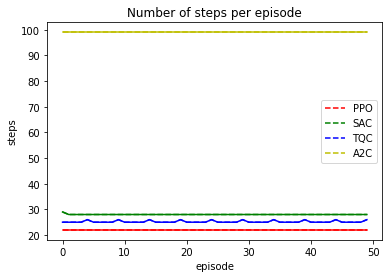

In [217]:
import numpy as np
import matplotlib.pyplot as plt  
x = list(range(0, 50))

l1=plt.plot(x,steps_PPO,'r--',label='PPO')
l2=plt.plot(x,steps_SAC,'g--',label='SAC')
l3=plt.plot(x,steps_TQC,'b--',label='TQC')
l4=plt.plot(x,steps_A2C,'y--',label='A2C')
plt.plot(x,steps_PPO,'r',x,steps_SAC,'g',x,steps_TQC,'b',x, steps_A2C,'y' )
plt.title('Number of steps per episode')
plt.xlabel('episode')
plt.ylabel('steps')
plt.legend()
# plt.show()
plt.savefig('steps_performance.png')

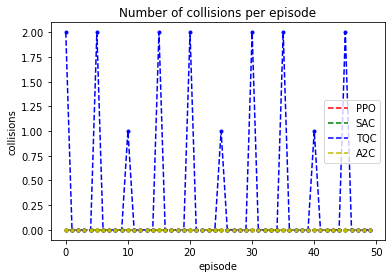

In [218]:
x = list(range(0, 50))
l1=plt.plot(x,collisions_PPO,'r--',label='PPO')
l2=plt.plot(x,collisions_SAC,'g--',label='SAC')
l3=plt.plot(x,collisions_TQC,'b--',label='TQC')
l4=plt.plot(x,collisions_A2C,'y--',label='A2C')
plt.plot(x,collisions_PPO,'r.', x,collisions_SAC,'g.',x,collisions_TQC, 'b.',x, collisions_A2C, 'y.' )
plt.title('Number of collisions per episode')
plt.xlabel('episode')
plt.ylabel('collisions')
plt.legend()
# plt.show()
plt.savefig('collisions_performance.png')